In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.set_default_dtype(torch.float64)
torch.autograd.set_detect_anomaly(True)

cuda


In [4]:
from pyspark.sql import SparkSession

# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Read CSV Example") \
    .getOrCreate()

# Đọc file CSV
df = spark.read.csv("origindata.csv", header=True, inferSchema=True)

# Hiển thị dữ liệu
df.show()


+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+-------------------------------

In [5]:
from pyspark.sql.functions import to_date

# Chuyển cột 'date' sang kiểu ngày (datetime)
df = df.withColumn('date', to_date('date', 'yyyy-MM-dd'))

# Sắp xếp theo 'location' và 'date'
df = df.orderBy(['location', 'date'])

In [6]:
from pyspark.sql.functions import col, count, when, mean
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType, StringType

# --- 1. Loại bỏ các cột có hơn 70% giá trị bị thiếu ---
row_count = df.count()
null_ratios = df.select([
    (count(when(col(c).isNull(), c)) / row_count).alias(c) for c in df.columns
])
null_ratios_dict = null_ratios.collect()[0].asDict()
columns_to_keep = [c for c, ratio in null_ratios_dict.items() if ratio < 0.7]
df = df.select(columns_to_keep)

# --- 2. Điền giá trị thiếu cho các cột số bằng trung bình ---
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType))]
for col_name in numeric_cols:
    mean_val = df.select(mean(col(col_name))).collect()[0][0]
    if mean_val is not None:
        df = df.fillna({col_name: mean_val})

# --- 3. Điền giá trị thiếu cho các cột chuỗi bằng mode (giá trị phổ biến nhất) ---
string_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
for col_name in string_cols:
    mode_val = df.groupBy(col_name).count().orderBy('count', ascending=False).first()
    if mode_val is not None:
        df = df.fillna({col_name: mode_val[0]})


In [7]:
df.head()

Row(iso_code='AFG', continent='Asia', location='Afghanistan', date=datetime.date(2020, 1, 5), total_cases=0, new_cases=0, new_cases_smoothed=8041.02576410559, total_deaths=0, new_deaths=0, new_deaths_smoothed=72.06082842751303, total_cases_per_million=0.0, new_cases_per_million=0.0, new_cases_smoothed_per_million=122.71385223352105, total_deaths_per_million=0.0, new_deaths_per_million=0.0, new_deaths_smoothed_per_million=0.7645298965747974, reproduction_rate=0.9114953710967834, new_vaccinations_smoothed=283875.815135185, new_vaccinations_smoothed_per_million=1851.477595639623, new_people_vaccinated_smoothed=106070.69886614944, new_people_vaccinated_smoothed_per_hundred=0.07467839543757489, stringency_index=0.0, population_density=54.42, median_age=18.6, aged_65_older=2.58, aged_70_older=1.34, gdp_per_capita=1803.99, extreme_poverty=13.924729240173251, cardiovasc_death_rate=597.03, diabetes_prevalence=9.59, female_smokers=10.772437926086475, male_smokers=33.09775758048625, handwashing_f

In [8]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lead

# Tạo window theo từng quốc gia, sắp xếp theo ngày
window_spec = Window.partitionBy('location').orderBy('date')

# Thêm cột new_cases_next_day
df = df.withColumn('new_cases_next_day', lead('new_cases').over(window_spec))


In [9]:
from pyspark.sql.types import DoubleType, IntegerType

# Lấy danh sách các cột kiểu số
numerical_cols = [
    field.name for field in df.schema.fields 
    if isinstance(field.dataType, (DoubleType, IntegerType))
    and field.name not in ['new_cases_next_day', 'population']
]


In [10]:
features_to_lag = [
    'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
    'reproduction_rate', 'stringency_index', 'total_vaccinations',
    'new_vaccinations_smoothed', 'positive_rate', 'new_tests_smoothed',
    'icu_patients', 'hosp_patients',
    'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita',
    'hospital_beds_per_thousand', 'life_expectancy'
]

In [11]:
actual_features_to_lag = [col for col in features_to_lag if col in df.columns]


In [12]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Tạo cửa sổ phân nhóm theo location, sắp xếp theo ngày
window_spec = Window.partitionBy('location').orderBy('date')

# Tạo các cột lag
for col_name in actual_features_to_lag:
    if col_name in numerical_cols:
        for i in range(1, 4):
            df = df.withColumn(f"{col_name}_lag_{i}", lag(col_name, i).over(window_spec))


In [13]:
# Drop toàn bộ các hàng có giá trị null (do tạo cột lag)
df = df.na.drop()

# Loại bỏ các cột gốc đã được tạo lag
columns_to_drop = [col for col in actual_features_to_lag if col in df.columns]
df = df.drop(*columns_to_drop)


In [14]:
df.printSchema()


root
 |-- iso_code: string (nullable = false)
 |-- continent: string (nullable = false)
 |-- location: string (nullable = false)
 |-- date: date (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = false)
 |-- total_cases_per_million: double (nullable = false)
 |-- new_cases_per_million: double (nullable = false)
 |-- new_cases_smoothed_per_million: double (nullable = false)
 |-- total_deaths_per_million: double (nullable = false)
 |-- new_deaths_per_million: double (nullable = false)
 |-- new_deaths_smoothed_per_million: double (nullable = false)
 |-- new_vaccinations_smoothed_per_million: double (nullable = false)
 |-- new_people_vaccinated_smoothed: double (nullable = false)
 |-- new_people_vaccinated_smoothed_per_hundred: double (nullable = false)
 |-- aged_70_older: double (nullable = false)
 |-- extreme_poverty: double (nullable = false)
 |-- cardiovasc_death_rate: double (nullable = false)
 |-- diabetes_prevalence: double (nu

In [16]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np

# Chọn các cột số, loại trừ 'new_cases_next_day' để không tính tương quan với chính nó
target_column = 'new_cases_next_day'
numerical_cols = [field.name for field in df.schema.fields 
                  if str(field.dataType) in ['DoubleType', 'IntegerType'] and field.name != target_column]

# Đảm bảo cột target tồn tại trong DataFrame
if target_column not in df.columns:
    raise ValueError(f"Cột '{target_column}' không tồn tại trong DataFrame.")

# Thêm target_column vào cuối để lấy hệ số tương quan với các cột khác
cols_for_corr = numerical_cols + [target_column]

# Assemble vector cho tất cả các cột liên quan
assembler = VectorAssembler(inputCols=cols_for_corr, outputCol='features')
df_vector = assembler.transform(df.select(cols_for_corr)).select('features')

# Tính ma trận tương quan Pearson
correlation_matrix = Correlation.corr(df_vector, 'features', method='pearson').head()[0]
cor_matrix_array = correlation_matrix.toArray()

# Vị trí của 'new_cases_next_day' trong vector
target_idx = len(cols_for_corr) - 1

# Tính hệ số tương quan giữa từng biến và biến mục tiêu
correlations_with_target = cor_matrix_array[:, target_idx]

# Hiển thị kết quả sắp xếp theo độ tương quan (giá trị tuyệt đối)
correlation_result = sorted(zip(cols_for_corr, correlations_with_target), key=lambda x: abs(x[1]), reverse=True)

print("--- Correlation with 'new_cases_next_day' ---")
for col, corr in correlation_result:
    if col != target_column:
        print(f"{col}: {corr:.4f}")


--- Correlation with 'new_cases_next_day' ---


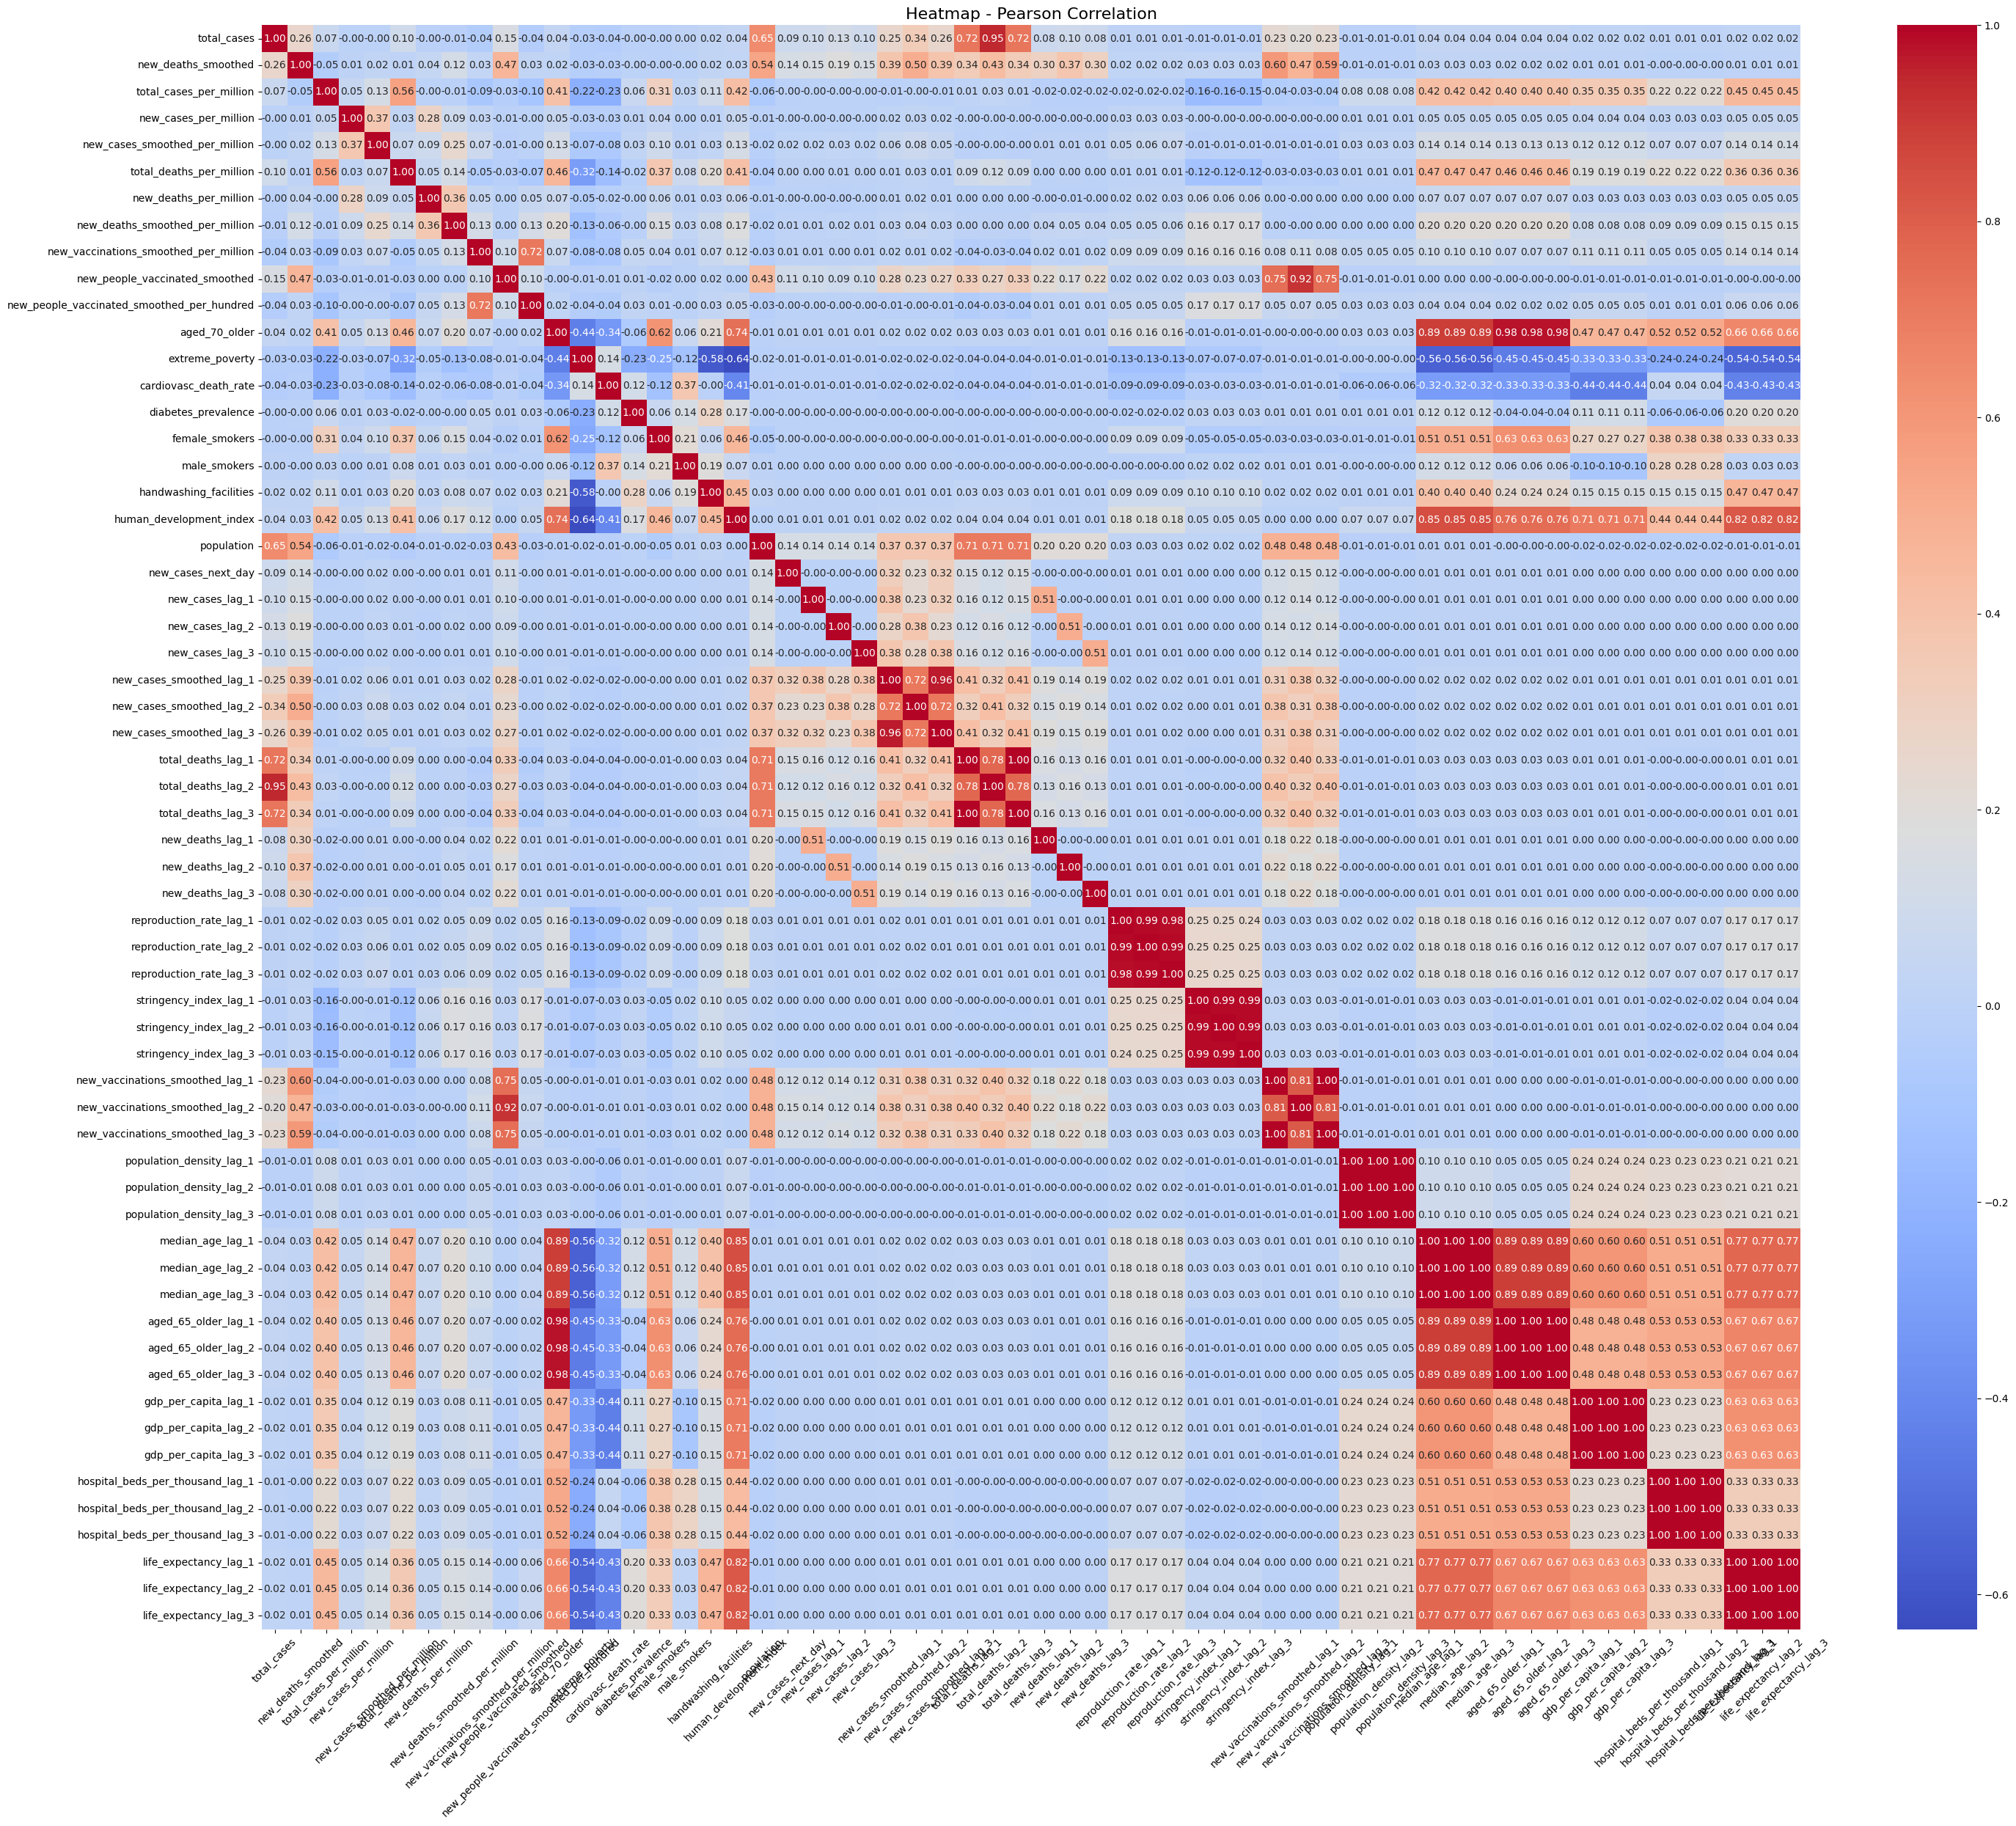

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn các cột dạng số
num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Tạo vector đặc trưng
vec_assembler = VectorAssembler(inputCols=num_cols, outputCol="features")
df_vec = vec_assembler.transform(df).select("features")

# Tính ma trận tương quan Pearson
corr_mat = Correlation.corr(df_vec, "features", "pearson").head()[0].toArray()

# Vẽ heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(corr_mat, xticklabels=num_cols, yticklabels=num_cols, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap - Pearson Correlation", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['new_cases_next_day'])
plt.title('Distribution of New Cases Next Day', fontsize=16)
plt.ylabel('New Cases Next Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(x='continent', y='new_cases_next_day', data=df)
plt.title('New Cases Next Day for each continents', fontsize=16)
plt.xlabel('Continent')
plt.ylabel('New Cases Next Day')
plt.xticks(rotation=45, ha='right') # Xoay nhãn để dễ đọc
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(y=df['new_cases_lag_1'])
plt.title('Distribution of New Cases Lag 1', fontsize=16)
plt.ylabel('New Cases Lag 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n" + "="*80 + "\n")

PySparkTypeError: [NOT_ITERABLE] Column is not iterable.

<Figure size 1000x600 with 0 Axes>